In [1]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.cluster.hierarchy import linkage, fcluster
import yfinance as yf
import time
import glob
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# DATA

In [2]:
# path to folder containing csv files. Each files correspond to an asset (stock)
folder_path = os.path.join("stocks", "datasets","dj30","raw", "*.csv")
csv_files = glob.glob(folder_path)
data_frames = []

for file in csv_files:
    # each file name is the stock symbol, so we simply extract sticker from the file's name
    symbol = os.path.splitext(os.path.basename(file))[0]
    print(f"processing {symbol} from {file}...")
    
    # parse "Date" column and filter the desired timeline (range). To be updated later !!!(problem with yahoo"s API)
    df = pd.read_csv(file, parse_dates=['Date'])
    #df = df.loc[~df.index.duplicated(keep='first')]
    mask = (df['Date'] >= '2010-01-01') & (df['Date'] <= '2018-12-21')
    df = df.loc[mask]
    # we only consider "Date" and "Adj Close" columns
    df = df[['Date', 'Adj Close']].set_index('Date')
    df.rename(columns={'Adj Close': symbol}, inplace=True)
    data_frames.append(df)

merged_df = pd.concat(data_frames, axis=1)
merged_df.sort_index(inplace=True)
print(merged_df.head())
#uncomment the next line to save the csv containing all stocks daily prices
#merged_df.to_csv("merged_historical_prices.csv")

processing CSCO from stocks/datasets/dj30/raw/CSCO.csv...
processing BA from stocks/datasets/dj30/raw/BA.csv...
processing V from stocks/datasets/dj30/raw/V.csv...
processing WBA from stocks/datasets/dj30/raw/WBA.csv...
processing MRK from stocks/datasets/dj30/raw/MRK.csv...
processing PG from stocks/datasets/dj30/raw/PG.csv...
processing CAT from stocks/datasets/dj30/raw/CAT.csv...
processing MCD from stocks/datasets/dj30/raw/MCD.csv...
processing INTC from stocks/datasets/dj30/raw/INTC.csv...
processing MMM from stocks/datasets/dj30/raw/MMM.csv...
processing KO from stocks/datasets/dj30/raw/KO.csv...
processing MSFT from stocks/datasets/dj30/raw/MSFT.csv...
processing HD from stocks/datasets/dj30/raw/HD.csv...
processing AXP from stocks/datasets/dj30/raw/AXP.csv...
processing CVX from stocks/datasets/dj30/raw/CVX.csv...
processing NKE from stocks/datasets/dj30/raw/NKE.csv...
processing IBM from stocks/datasets/dj30/raw/IBM.csv...
processing GS from stocks/datasets/dj30/raw/GS.csv...


In [ ]:
#### You can ignore this part, i used SP500 for regime switching model but it didn't work for a univariate RSM
#### Will consider a multivariate RSM later (probably for the final version)

"""DON'T RUN THIS PART !!!!!
"""
path = os.path.join("stocks", "datasets","dj30", 'SP500.csv')
sp500_df = pd.read_csv(path, parse_dates=['Date'])
#sp500_df['Date'] = pd.to_datetime(sp500_df['Date'], format='%m/%d/%Y')
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'], infer_datetime_format=True, errors='coerce')
sp500_df.dropna(subset=['Date'], inplace=True)
mask = (sp500_df['Date'] >= '2010-01-01') & (sp500_df['Date'] <= '2022-01-01')
sp500_df = sp500_df.loc[mask]
sp500_prices = sp500_df[['Date', 'Close']].copy()
sp500_prices.rename(columns={'Close': 'SP500'}, inplace=True)
sp500_prices.set_index('Date', inplace=True)
df = merged_df
df = df.merge(sp500_prices, left_index=True, right_index=True, how='outer')
df.sort_index(inplace=True)
df.fillna(method='ffill', inplace=True)
columns, shape = df.columns, df.shape
print(columns,shape)

# Correlation clustering

In [3]:
# non overlapping windows to compute correlation matrices
log_returns = np.log(merged_df / merged_df.shift(1)).dropna()
window_size = 120
correlation_matrices = []
for start in range(0, len(log_returns) - window_size + 1, window_size):
    window_data = log_returns.iloc[start:start+window_size]
    corr_matrix = window_data.corr().values
    correlation_matrices.append(corr_matrix)
    
# we vectorize the upper triangular part
n_assets = log_returns.shape[1]
features = [mat[np.triu_indices(n_assets, k=1)] for mat in correlation_matrices]
features = np.array(features)

# Ward's method for hierarchical clustering
Z = linkage(features, method='ward')
n_clusters = 4
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')

# representative corr matrix for each cluster
rep_corr_matrices = []
for cluster_id in range(1, n_clusters + 1):
    indices = np.where(clusters == cluster_id)[0]
    avg_corr = np.mean([correlation_matrices[i] for i in indices], axis=0)
    rep_corr_matrices.append(avg_corr)

print("\nrepresentative correlation matrices:")
for i, mat in enumerate(rep_corr_matrices):
    print(f"Matrix {i+1}:\n", mat)


representative correlation matrices:
Matrix 1:
 [[1.         0.60223916 0.50979559 0.42526413 0.5292338  0.54682248
  0.57915034 0.52727064 0.61714518 0.58363057 0.52672298 0.626071
  0.55738858 0.58374095 0.55964899 0.60501455 0.61717579 0.51179685
  0.57740281 0.59665919 0.50516454 0.45169556 0.45988273 0.64904691
  0.56046428 0.47443405 0.55766824 0.598461   0.49437491]
 [0.60223916 1.         0.53531331 0.53586055 0.58939395 0.58578008
  0.66365553 0.5936087  0.58290002 0.69187961 0.6100825  0.60504659
  0.65455634 0.66052892 0.64869323 0.69865926 0.64261893 0.56747819
  0.65307496 0.6782365  0.53876556 0.53467584 0.55707355 0.80343554
  0.57820595 0.46967951 0.60700322 0.65516443 0.49695584]
 [0.50979559 0.53531331 1.         0.3911563  0.46075988 0.442936
  0.48931688 0.52219165 0.42847978 0.55933469 0.46456168 0.45013076
  0.51920911 0.57302825 0.52076999 0.55923162 0.50782388 0.43206832
  0.47992509 0.53414585 0.47989278 0.41905059 0.39953572 0.57074935
  0.5004553  0.34061823

# Monte Carlo Simulation

In [4]:
annual_factor = 252  # trading days per year
annual_drift = log_returns.mean() * annual_factor # drift (return) for each asset
annual_vol = log_returns.std() * np.sqrt(annual_factor)  # volatility for each asset
mu = annual_drift.values    
sigmas = annual_vol.values   

# for starting prices, we use the last available prices from our original df
S0s = merged_df.iloc[-1].values

# pre-simulation config
T = 1       # 1 year
dt = 1 / 252  # daily step
n_steps = int(T / dt)

def simulate_correlated_prices(S0s, mu, sigmas, T, dt, corr_matrix):
    """
    single price trajectory using the Black-Scholes-Merton model
    """
    n_assets = len(S0s)
    n_steps = int(T / dt)
    prices = np.zeros((n_steps + 1, n_assets))
    prices[0] = S0s
    L = np.linalg.cholesky(corr_matrix)  # we use cholesky for correlated noise
    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, size=n_assets)
        correlated_Z = L @ Z
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigmas**2) * dt + sigmas * np.sqrt(dt) * correlated_Z)
    return prices

def simulate_multiple_paths(S0s, mu, sigmas, T, dt, corr_matrix, num_paths=1000):
    """
    here, we generate multiple simulation paths for a given correlation matrix
    """
    sims = []
    for _ in range(num_paths):
        sim = simulate_correlated_prices(S0s, mu, sigmas, T, dt, corr_matrix)
        sims.append(sim)
    return np.array(sims)

# generate multiple simulation trajectories for each representative correlation matrix, 
all_simulations = {}
num_paths = 1000  # 1000 trajectories per rep matrix
for idx, corr in enumerate(rep_corr_matrices):
    sims = simulate_multiple_paths(S0s, mu, sigmas, T, dt, corr, num_paths=num_paths)
    all_simulations[idx] = sims
    print(f"representative Matrix {idx+1}: {sims.shape[0]} trajectories generated")

# we combine all simulations
combined_simulations = np.concatenate(list(all_simulations.values()), axis=0)
print("combined simulation trajectories shape:", combined_simulations.shape)

representative Matrix 1: 1000 trajectories generated
representative Matrix 2: 1000 trajectories generated
representative Matrix 3: 1000 trajectories generated
representative Matrix 4: 1000 trajectories generated
combined simulation trajectories shape: (4000, 253, 29)


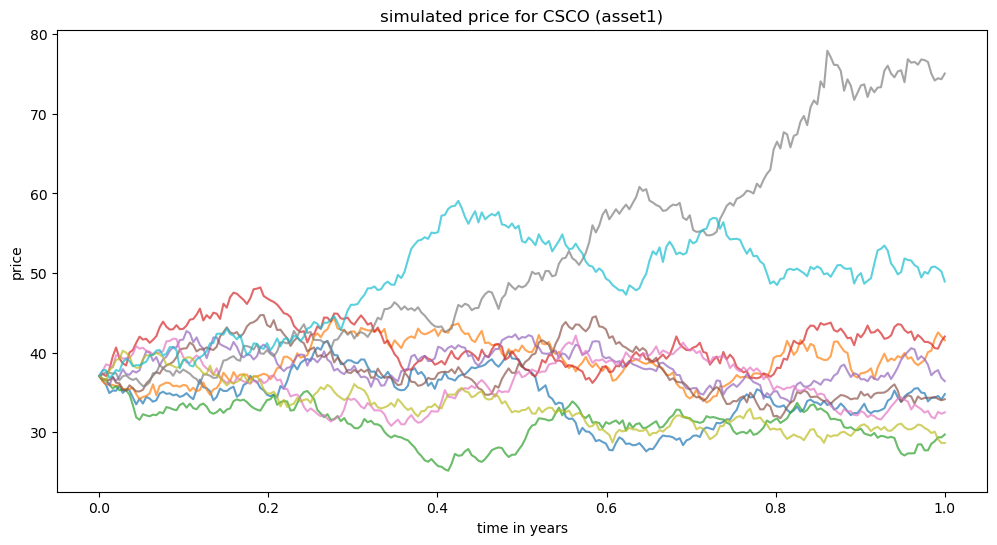

In [5]:
# for plot, we consider the first asset
asset_index = 0
# we randomly select 10 simulations
num_to_plot = 10
total_paths = combined_simulations.shape[0]
sample_indices = np.random.choice(total_paths, size=num_to_plot, replace=False)
# time vector
n_steps_plus_1 = combined_simulations.shape[1]
time = np.linspace(0, 1, n_steps_plus_1)  # time in years
plt.figure(figsize=(12, 6))
for idx in sample_indices:
    plt.plot(time, combined_simulations[idx, :, asset_index], alpha=0.7)

plt.title(f"simulated price for CSCO (asset1)")
plt.xlabel("time in years")
plt.ylabel("price")
plt.show()